In [3]:
from datasets import load_dataset, concatenate_datasets
import json
import torch
from datasets.utils.logging import disable_progress_bar,enable_progress_bar
import os
import numpy as np

import matplotlib.pyplot as plt


In [2]:
dataset_name = "multirc_n_shot"
dataset_name_hf = "hassansh/"+ dataset_name # The dataset name in Hugging Face Datasets

num_shots = 0
dataset = load_dataset(dataset_name_hf, name = f"{num_shots}_shot")['test']
idx = range(dataset.num_rows)
dataset = dataset.add_column("idx", idx)
print(dataset)

# make a dict of questions for the same paragraph
disable_progress_bar()
num_qs_all = 953
# q_list = torch.zeros(dataset.num_rows)
q_list = {}
ans_list = {}
# ans_list = torch.zeros(dataset.num_rows)
step = 100
for q in range(num_qs_all):
    dd = dataset.filter(lambda example: example['question']==q)
    q_list[f"{q}"] = []
    ans_list[f"{q}"] = []
    for ind in range(dd.num_rows):
        # q_list[dd[ind]['idx']] = q
        # ans_list[dd[ind]['idx']] = dd[ind]['target']
        q_list[f"{q}"].append(dd[ind]['idx'])
        ans_list[f"{q}"].append(dd[ind]['target'])

    if q % step == 0:
        print(f"{q//step}", end='\r')
# print(num_qs_all)
enable_progress_bar()

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 505.09it/s]
Generating test split: 4848 examples [00:00, 136018.74 examples/s]


Dataset({
    features: ['question', 'input', 'target_str', 'target', 'idx'],
    num_rows: 4848
})


In [120]:
print(ans_list["1"])

[0, 0, 1, 1, 0]


In [19]:
model_name = "Llama-2-7b-hf/"
# model_name = "Mistral-7B-v0.1/"
folder_in = "gromovand/" + model_name
num_shots = 0
path_to_results = folder_in + dataset_name + f"_{num_shots}/"
log_address_acc = os.path.join(path_to_results, "accuracy_per_question.json")

with open(log_address_acc, 'r') as log_file:
    # Read the log file line by line
    for line in log_file:
        acc_list = json.loads(line)

acc_list = torch.tensor(acc_list, dtype= torch.int8)
print(acc_list.shape)

torch.Size([4848])


In [20]:
F1_list = []
noTpos =[]
nopos =[]
EM = 0 # exact match
for q in range(num_qs_all):
    # print(acc_list[q_list[f"{q}"]])
    TA_arr = torch.argwhere(acc_list[q_list[f"{q}"]]==1)[:,0] # correc answers
    FA_arr = torch.argwhere(acc_list[q_list[f"{q}"]]==0)[:,0] # wrong answers
    GP_arr = torch.argwhere(torch.tensor(ans_list[f"{q}"])==1)[:,0] # ground positive
    GN_arr = torch.argwhere(torch.tensor(ans_list[f"{q}"])==0)[:,0] # ground negative
    # print(q, TA,FA,GP,GN)
    GP = GP_arr.shape[0]
    TP = np.intersect1d(TA_arr,GP_arr).shape[0]
    TN = np.intersect1d(TA_arr,GN_arr).shape[0]
    FP = np.intersect1d(FA_arr,GN_arr).shape[0]
    FN = np.intersect1d(FA_arr,GP_arr).shape[0]
    if FA_arr.shape[0]==0:
        # print(q)
        EM += 1
    # print(TP.shape, TN.shape)
    # if (TP.shape[0]+ FP.shape[0])> 0:
        # if TP.shape[0]>0:
            # precision = TP.shape[0]/(TP.shape[0]+ FP.shape[0])
            # recall = TP.shape[0]/GP.shape[0]
            # F1_list.append( 2*precision*recall/(precision+recall))
    if TP+FP+GP >0 :
        F1_list.append(2*TP/(TP+FP+ GP))
    # else:
    #     F1_list.append(1)

    #     # else:
    #         noTpos.append(q)
    # else:
    #     nopos.append(q)

F1_list = torch.tensor(F1_list)
print(f"F1_a: {F1_list.mean().item():.3f}, {F1_list.std().item()/(F1_list.shape[0]-1)**0.5:.3f}, over {F1_list.shape[0]}")
print(f"EM: {EM/num_qs_all:.3f}")

# # for i in range(acc_list.shape[0]):
TA = torch.argwhere(acc_list==1) # correc answers
FA = torch.argwhere(acc_list==0) # wrong answers
ans_full_list = dataset['target']
GP = torch.argwhere(torch.tensor(ans_full_list)==1) # ground positive
GN = torch.argwhere(torch.tensor(ans_full_list)==0) # ground negative
TP = np.intersect1d(TA,GP)
TN = np.intersect1d(TA,GN)
FP = np.intersect1d(FA,GN)
FN = np.intersect1d(FA,GP)
# print(TP.shape, TN.shape)
precision = TP.shape[0]/(TP.shape[0]+ FP.shape[0])
recall = TP.shape[0]/GP.shape[0]
F1 = 2*precision*recall/(precision+recall)

print(f"F1_tot: {F1:.3f}")


F1_a: 0.550, 0.008, over 952
EM: 0.042
F1_tot: 0.593


Llama-2-7B

w prompt
F1_a: 0.327, 0.011, over 952
EM: 0.049
F1_tot: 0.437

w/o prompt True/False:
F1_a: 0.197, 0.010, over 952
EM: 0.024
F1_tot: 0.336

F1_a: 0.550, 0.008, over 952
EM: 0.042
F1_tot: 0.593

---------------------
Mistral:
F1_a: 0.626, 0.007, over 953
EM: 0.083
F1_tot: 0.638

F1_a: 0.728, 0.008, over 953
EM: 0.275
F1_tot: 0.741

# 0.4721526503562927 0.011244376819454057 953
# 0.5733551383018494 0.0068698085200768555 953
# torch.argwhere(torch.tensor(ans_full_list)==1)

In [11]:
print(len(nopos), len(noTpos))
idx = 10
arr = noTpos
print(arr[idx])
print(acc_list[q_list[f"{arr[idx]}"]].tolist())
print( ((acc_list[q_list[f"{arr[idx]}"]] + 2+~torch.tensor(ans_list[f"{arr[idx]}"])) %2).tolist())
print(ans_list[f"{arr[idx]}"])


0 0


IndexError: list index out of range

In [93]:
2+~torch.tensor([0,1])

tensor([1, 0])

## parsing data for plot vs number of removed layers

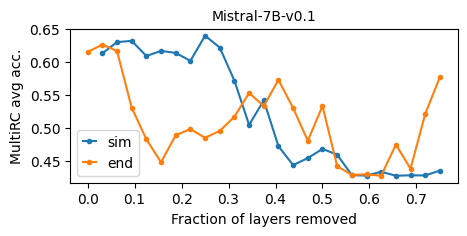

In [31]:
## accuracy

num_shots = 0
def file_reader(out_dir, model_name, n_list, cossim= True):
    acc = []
    if cossim:
        # out_dir = "cossim_results/"
        out_dir += f"{model_name.split('/')[-1]}/"
        for num_layer_dropped in n_list:
            file_dir = out_dir+ f"num_ldrop_{num_layer_dropped}_shots_{num_shots}/"
            fname = file_dir+ "accuracy.json"

            if os.path.exists(fname):
                f = open(fname)
                data = json.load(f)
                f.close()
                acc.append(data)
            else:
                acc.append(0)
    else:
        # out_dir = "results/"
        out_dir += f"{model_name.split('/')[-1]}/"
        for num_layer_dropped in n_list:
            first_layer_dropped = depth - num_layer_dropped -1
            file_dir =  out_dir + f"num_ldrop_{first_layer_dropped}_shots_{num_shots}/"
            fname = file_dir+ "accuracy.json"

            if os.path.exists(fname):
                f = open(fname)
                data = json.load(f)
                f.close()
                acc.append(data)
            else:
                acc.append(0)
    
    return acc


model_name = "mistralai/Mistral-7B-v0.1"
# model_name = "meta-llama/Llama-2-70b-hf"
depth = 32
n1_list = np.arange(1,25)

out_dir = "cossim_results_no_prompt/"
acc_cs = file_reader(out_dir, model_name, n1_list)
# out_dir = "results/"

n2_list = np.arange(25)
out_dir = "results_no_prompt/"
acc = file_reader(out_dir, model_name, n2_list, cossim= False)


# boolq_accs_llama2_70B = np.array([0.8550267885282068, 0.8555783170501102, 0.8558146864166404, 0.850141821619918, 0.8474629687992437, 0.8525055152852189, 0.8495902930980146, 0.8491175543649543, 0.760163882760794, 0.7799401197604791, 0.8271352032776552, 0.6910652379451623, 0.6935865111881502, 0.6809013551843681, 0.6216514339741569, 0.603135833595966])
# layers_removed_llama2_70B = 79 - np.array([78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18])

plt.figure(figsize=(5,2))
plt.plot(n1_list/depth, acc_cs, ".-",color="C0", label = "sim")

plt.plot(n2_list/depth, acc, ".-",color="C1", label = "end")
plt.ylabel(r"MultiRC avg acc.")
plt.xlabel("Fraction of layers removed")
plt.title(model_name.split("/")[-1],fontsize=10)
plt.legend(handlelength=1)
plt.show()


In [35]:
## F1-score

def calculate_F1(acc_list):
    F1_list = []
    EM = 0 # exact match
    for q in range(num_qs_all):
        # print(acc_list[q_list[f"{q}"]])
        TA_arr = torch.argwhere(acc_list[q_list[f"{q}"]]==1)[:,0] # correc answers
        FA_arr = torch.argwhere(acc_list[q_list[f"{q}"]]==0)[:,0] # wrong answers
        GP_arr = torch.argwhere(torch.tensor(ans_list[f"{q}"])==1)[:,0] # ground positive
        GN_arr = torch.argwhere(torch.tensor(ans_list[f"{q}"])==0)[:,0] # ground negative
        # print(q, TA,FA,GP,GN)
        GP = GP_arr.shape[0]
        TP = np.intersect1d(TA_arr,GP_arr).shape[0]
        TN = np.intersect1d(TA_arr,GN_arr).shape[0]
        FP = np.intersect1d(FA_arr,GN_arr).shape[0]
        FN = np.intersect1d(FA_arr,GP_arr).shape[0]
        if FA_arr.shape[0]==0:
            EM += 1
        if TP+FP+GP >0 :
            F1_list.append(2*TP/(TP+FP+ GP))

    F1_list = torch.tensor(F1_list)
    F1_avg = F1_list.mean().item()
    dF1 = F1_list.std().item()/(F1_list.shape[0]-1)**0.5
    # print(f"Averaged over {F1_list.shape[0]}")
    # print(f"EM: {EM/num_qs_all:.3f}")

    TA = torch.argwhere(acc_list==1) # correc answers
    FA = torch.argwhere(acc_list==0) # wrong answers
    ans_full_list = dataset['target']
    GP = torch.argwhere(torch.tensor(ans_full_list)==1) # ground positive
    GN = torch.argwhere(torch.tensor(ans_full_list)==0) # ground negative
    TP = np.intersect1d(TA,GP)
    TN = np.intersect1d(TA,GN)
    FP = np.intersect1d(FA,GN)
    FN = np.intersect1d(FA,GP)
    # print(TP.shape, TN.shape)
    precision = TP.shape[0]/(TP.shape[0]+ FP.shape[0])
    recall = TP.shape[0]/GP.shape[0]
    F1_tot = 2*precision*recall/(precision+recall)

    return F1_avg, dF1, F1_tot

num_shots = 0
def file_reader(out_dir, model_name, n_list, cossim= True):
    F1_all = []
    F1_a = []
    dF1_a = []
    if cossim:
        # out_dir = "cossim_results/"
        out_dir += f"{model_name.split('/')[-1]}/"
        for num_layer_dropped in n_list:
            file_dir = out_dir+ f"num_ldrop_{num_layer_dropped}_shots_{num_shots}/"
            # fname = file_dir+ "accuracy.json"
            fname = file_dir+ "accuracy_per_question.json"
            if os.path.exists(fname):
                with open(fname, 'r') as log_file:
                    # Read the log file line by line
                    for line in log_file:
                        acc_list = json.loads(line)

                acc_list = torch.tensor(acc_list, dtype= torch.int8)
                F1, dF1, F1_tot = calculate_F1(acc_list)
                F1_a.append(F1)
                dF1_a.append(dF1)
                F1_all.append(F1_tot)
            else:
                F1_a.append(0)
                dF1_a.append(0)
                F1_all.append(0)

    else:
        # out_dir = "results/"
        out_dir += f"{model_name.split('/')[-1]}/"
        for num_layer_dropped in n_list:
            first_layer_dropped = depth - num_layer_dropped -1
            file_dir =  out_dir + f"num_ldrop_{first_layer_dropped}_shots_{num_shots}/"
            fname = file_dir+ "accuracy_per_question.json"

            if os.path.exists(fname):
                with open(fname, 'r') as log_file:
                    # Read the log file line by line
                    for line in log_file:
                        acc_list = json.loads(line)

                acc_list = torch.tensor(acc_list, dtype= torch.int8)
                F1, dF1, F1_tot = calculate_F1(acc_list)
                F1_a.append(F1)
                dF1_a.append(dF1)
                F1_all.append(F1_tot)
            else:
                F1_a.append(0)
                dF1_a.append(0)
                F1_all.append(0)
    
    return np.array(F1_a), np.array(dF1_a), np.array(F1_all)


model_name = "mistralai/Mistral-7B-v0.1"
# model_name = "meta-llama/Llama-2-70b-hf"
depth = 32
n1_list = np.arange(1,25)

out_dir = "cossim_results_no_prompt/"
F1_cs, dF1_cs, F1_all_cs = file_reader(out_dir, model_name, n1_list)
# out_dir = "results/"

n2_list = np.arange(0,25)
out_dir = "results_no_prompt/"
F1_end, dF1_end, F1_all_end = file_reader(out_dir, model_name, n2_list, cossim= False)


# boolq_accs_llama2_70B = np.array([0.8550267885282068, 0.8555783170501102, 0.8558146864166404, 0.850141821619918, 0.8474629687992437, 0.8525055152852189, 0.8495902930980146, 0.8491175543649543, 0.760163882760794, 0.7799401197604791, 0.8271352032776552, 0.6910652379451623, 0.6935865111881502, 0.6809013551843681, 0.6216514339741569, 0.603135833595966])
# layers_removed_llama2_70B = 79 - np.array([78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18])


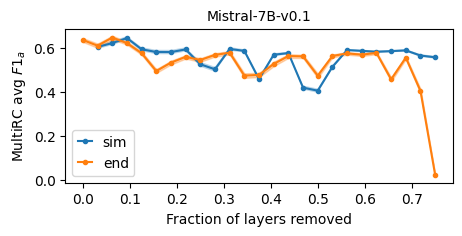

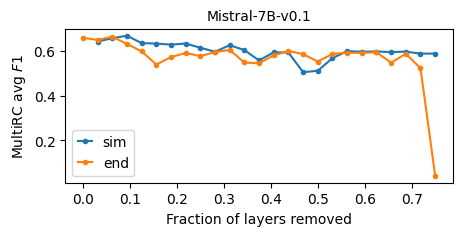

In [37]:
plt.figure(figsize=(5,2))
plt.fill_between(n1_list/depth, F1_cs-dF1_cs, F1_cs+dF1_cs,facecolor="C0", alpha=.3)
plt.plot(n1_list/depth, F1_cs, ".-",color="C0", label = "sim")

# plt.plot(layers_removed_llama2_70B/depth, boolq_accs_llama2_70B, ".-",label="old method")
plt.fill_between(n2_list/depth, F1_end-dF1_end, F1_end+dF1_end, color="C1", alpha=.3)
plt.plot(n2_list/depth, F1_end, ".-",color="C1", label = "end")
plt.ylabel(r"MultiRC avg $F1_a$")
plt.xlabel("Fraction of layers removed")
plt.title(model_name.split("/")[-1],fontsize=10)
plt.legend(handlelength=1)
plt.show()

plt.figure(figsize=(5,2))
plt.plot(n1_list/depth, F1_all_cs, ".-",color="C0", label = "sim")
plt.plot(n2_list/depth, F1_all_end, ".-",color="C1", label = "end")
plt.ylabel(r"MultiRC avg $F1$")
plt.xlabel("Fraction of layers removed")
plt.title(model_name.split("/")[-1],fontsize=10)
plt.legend(handlelength=1)
plt.show()